# DSE Course 1, Session 5: Regression and Analysis

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will look at fitting data to a curve using **regression**. We will also look at using regression to make **predictions** for new data points by dividing our data into a training and a testing set. Finally we will examine how much error we make in our fit and then in our predictions by computing the mean squared error, at the variance and bias.

<br>

---


### Load libraries which will be needed in this Notebook



In [ ]:
# Pandas library for the pandas dataframes
import pandas as pd    

# Import Scikit-Learn library for the regression models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import numpy 
import numpy as np

# Import plotting libraries
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
from ipywidgets import interact

# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 20})

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2


## 5.1 What is regression? 

It is the process of finding a relationship between **_dependent_** and **_independent_** variables to find trends in data. This abstract definition means that you have one variable (the dependent variable) which depends on one or more variables (the independent variables). One of the reasons for which we want to regress data is to understand whether there is a trend between two variables. 

For instance, let's say we had data points showing how tired we are respective to the amount of coffee we drink. In the case of linear regression, the question would be - is the data quantity of how tired I am linearly proportional to the amount of coffee I drink, i.e. can we use a line to represent the relationship between these two variables?




## 5.2  Linear regression fitting with scikit-learn

### 5.2.1 Loading the dataset

Here we'll load in our wine dataset

```
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/ds_for_engineers/main/data/wine_quality/winequalityN.csv")
```



In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/ds_for_engineers/main/data/wine_quality/winequalityN.csv")
df.shape

(6497, 13)

#### Exercise 1: rudimentary EDA
What does the data look like? Remember how to visualize data in a pandas dataframe (Sessions 3 and 4) 

<ol>
<li> for every column calculate the

  * skew
  * kurtosis
  * pearsons correlation with the target variable
  * number of missing entries 

and organize this into a new dataframe

<li> repeat this exercise, this time differentiating between the red and white wine types

In [ ]:
# Cell for exercise 1

skew = df.skew()
kurt = df.kurtosis()
pear = df.corr()['quality']
spear = df.corr('spearman')['quality']
null = df.isnull().sum()

dff = pd.DataFrame([skew, kurt, pear, spear, null])
dff = dff.T
dff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'null count']
dff

,skew,kurtosis,pearsons _quality,spearman _quality,null count
fixed acidity,1.722805,5.057727,-0.077031,-0.098669,10.0
volatile acidity,1.495512,2.827081,-0.265953,-0.258272,8.0
citric acid,0.473032,2.401582,0.085706,0.105916,3.0
residual sugar,1.435000,4.358134,-0.036825,-0.016766,2.0
chlorides,5.399849,50.894874,-0.200886,-0.295350,2.0
free sulfur dioxide,1.220066,7.906238,0.055463,0.086865,0.0
total sulfur dioxide,-0.001177,-0.371664,-0.041385,-0.054777,0.0
density,0.503602,6.606067,-0.305858,-0.322806,0.0
pH,0.386966,0.370068,0.019366,0.032278,9.0
sulphates,1.798467,8.659892,0.038729,0.030047,4.0


In [ ]:
# Cell for exercise 1

red = df.loc[df['type'] == 'red']
wht = df.loc[df['type'] == 'white']

skew = red.skew()
kurt = red.kurtosis()
pear = red.corr()['quality']
spear = red.corr('spearman')['quality']
null = red.isnull().sum()
med = red.median()

dff = pd.DataFrame([skew, kurt, pear, spear, null, med])
dff = dff.T
dff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'null count', 'median']
dff

skew = wht.skew()
kurt = wht.kurtosis()
pear = wht.corr()['quality']
spear = wht.corr('spearman')['quality']
null = wht.isnull().sum()
med = wht.median()

dffw = pd.DataFrame([skew, kurt, pear, spear, null, med])
dffw = dffw.T
dffw.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'null count', 'median']

desc = pd.concat([dff, dffw], keys=['red', 'white'])

In [ ]:
list(desc.unstack().index).append('purple')

In [ ]:
def my_fig(metric=desc.columns):
  fig, ax = plt.subplots(1, 1, figsize=(10,10))
  pd.DataFrame(desc[metric]).unstack()[metric].T.plot(kind='barh', ax=ax)

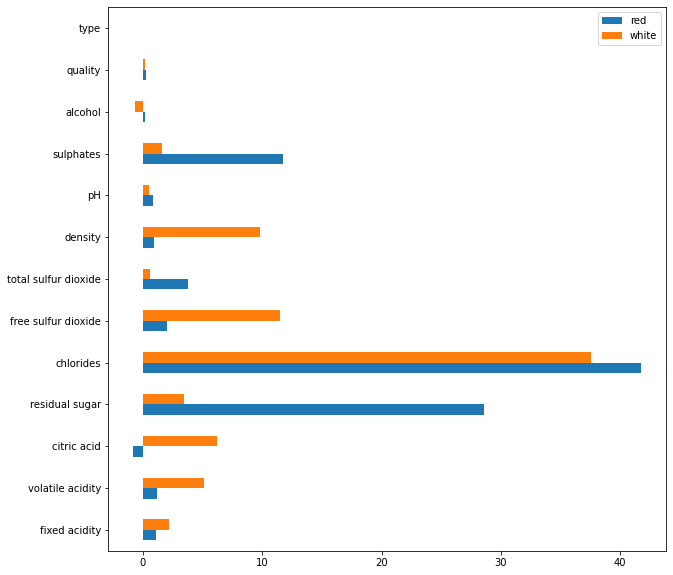

In [ ]:
interact(my_fig)

### 5.2.2 Visualizing the data set

We can create a scatter plot of fixed acidity vs density of red wine in the dataset using the <code> df.plot() </code> function (as discussed in Session 4)

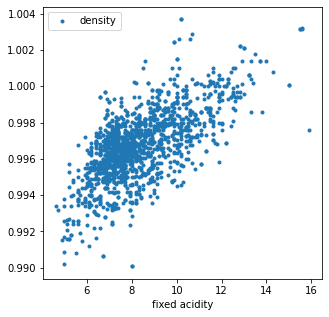

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df.loc[df['type'] == 'red'].plot(x='fixed acidity', y='density', ax=ax, 
                                 ls='', marker='.')

### 5.2.3 Linear regression - fitting data to a line

It looks like density increases with fixed acidity following a line, maybe something like

$$y(t)= m\cdot t + b  \;\;\;\;\;\;\;\;\sf{eq. 1}$$ 

with $y=\sf density$, $t=\sf fixed acidity$, $m$ the slope and $b$ the intercept. 

To solve the problem, we need to find the values of $b$ and $m$ in equation 1 to best fit the data. This is called **linear regression**.

In linear regression our goal is to minimize the error between computed values of positions $y^{\sf calc}(t_i)\equiv y^{\sf calc}_i$ and known values $y^{\sf exact}(t_i)\equiv y^{\sf exact}_i$, i.e. find $b$ and $m$ which lead to lowest value of

$$\epsilon (m,b) =\sum_{i=1}^{N_{\sf time points}}\left(y^{\sf exact}_i - y^{\sf calc}_i\right)^2 = \sum_{i=1}^{N_{\sf time points}}\left(y^{\sf exact}_i - m\cdot t_i - b \right)^2\;\;\;\;\;\;\;\;\;\;\;\sf{eq. 2}$$

To find out more see e.g. https://en.wikipedia.org/wiki/Simple_linear_regression

#### Question 1: linear regression loss function
> Do we always want *m* and *b* to be large positive numbers so as to minimize eq. 2? 

### 5.2.4 The scikit-learn library

Luckily there is a Python library called [scikit-learn](https://scikit-learn.org/stable/) which contains many functions related to regression including [linear regression](https://scikit-learn.org/stable/modules/linear_model.html). 

The function we will use is called <code> LinearRegression() </code>. 

### 5.2.5 Fitting acidity vs density data to a line

```
# Create linear regression object
regr = linear_model.LinearRegression()

# Use model to fit to the data, the X values are densities and the Y values are fixed acidity
# Note that we need to reshape the vectors to be of the shape X - (n_samples, n_features) and Y (n_samples, n_targets)
X = red['density'].values.reshape(-1, 1)
Y = red['fixed acidity'].values.reshape(-1, 1)
```

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Use model to fit to the data, the X values are densities and the Y values are fixed acidity
# Note that we need to reshape the vectors to be of the shape X - (n_samples, n_features) and Y (n_samples, n_targets)
X = red['density'].values.reshape(-1, 1)
Y = red['fixed acidity'].values.reshape(-1, 1)


```
print(red['density'].values.shape, red['fixed acidity'].values.shape)
print(X.shape, Y.shape)
```

In [ ]:
print(red['density'].values.shape, red['fixed acidity'].values.shape)
print(X.shape, Y.shape)

(1599,) (1599,)
(1599, 1) (1599, 1)


```
# Fit to the data
regr.fit(X, Y)

# Extract the values of interest
m = regr.coef_[0][0]
b = regr.intercept_[0]

# Print the slope m and intercept b
print('Scikit learn - Slope: ', m , 'Intercept: ', b )
```

What happens when we try to fit the data as is?

In [ ]:
# Fit to the data
# regr.fit(X, Y)

Let's look back at our dataset description dataframe above, what do we notice, what contains null values?

There are several strategies for dealing with null values. For now let's take the simplest case, and drop rows in our dataframe that contain null

In [ ]:
X = red[['density', 'fixed acidity']].dropna(axis=0)['density'].values.reshape(-1, 1)
Y = red[['density', 'fixed acidity']].dropna(axis=0)['fixed acidity'].values.reshape(-1, 1)

In [ ]:
# Fit to the data
regr.fit(X, Y)

# Extract the values of interest
m = regr.coef_[0][0]
b = regr.intercept_[0]

# Print the slope m and intercept b
print('Scikit learn - Slope: ', m , 'Intercept: ', b )

Scikit learn - Slope:  616.0131428066102 Intercept:  -605.6880086750525


#### Exercise 2: calculating Y_pred
Estimate the values of $y$ by using your fitted parameters. Hint: Use your <code>regr.coef_</code> and <code>regr.intercept_</code> parameters to estimate Y_calc_2 following equation 1


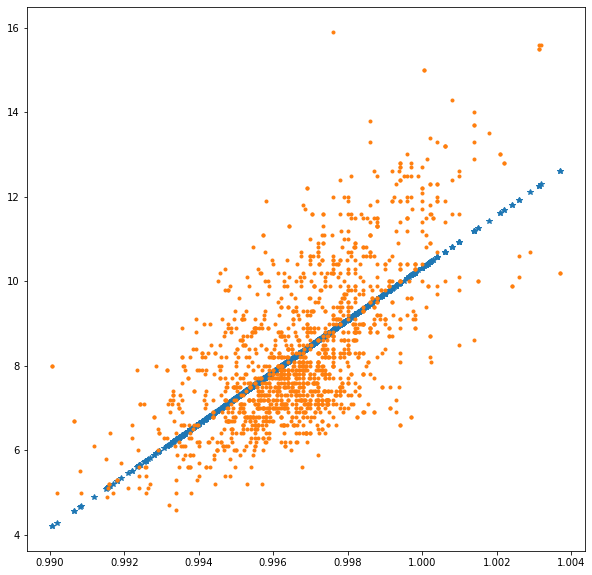

In [ ]:
Y_pred = m * X + b
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(X, Y_pred, ls='', marker='*')
ax.plot(X, Y, ls='', marker='.')

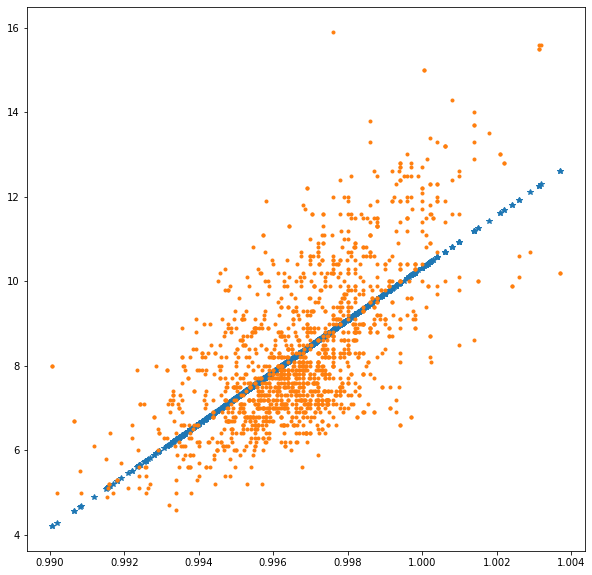

In [ ]:
# Another way to get this is using the regr.predict function
Y_calc = regr.predict(X)
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(X, Y_calc, ls='', marker='*')
ax.plot(X, Y, ls='', marker='.')

## 5.3 How much error are we making? 

### 5.3.1 Mean Squared Error

The plot in Section 5.2.5 looks good, but numerically what is our error? What is the mean value of $\epsilon$, i.e. the **Mean Squared Error (MSE)**?

$${\sf MSE}=\epsilon_{\sf ave} = \frac{\sum_{i=1}^{N_{\sf times}}\left(y^{\sf exact}_i - m\cdot t_i - b \right)^2}{N_{\sf times}}\;\;\;\;\;\sf eq. 3$$

```
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(Y, Y_calc))
```

In [ ]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(Y, Y_calc))

Mean squared error: 1.68


Another way to measure error is the regression score, $R^2$. $R^2$ is generally defined as the ratio of the total sum of squares $SS_{\sf tot} $ to the residual sum of squares $SS_{\sf res} $:

$$SS_{\sf tot}=\sum_{i=1}^{N} \left(y^{\sf exact}_i-\bar{y}\right)^2\;\;\;\;\; \sf eq. 4$$
$$SS_{\sf res}=\sum_{i=1}^{N} \left(y^{\sf exact}_i - y^{\sf calc}_i\right)^2\;\;\;\;\; \sf eq. 5$$
$$R^2 = 1 - {SS_{\sf res}\over SS_{\sf tot}} \;\;\;\;\;\; \sf eq. 6$$

In eq. 4, $\bar{y}=\sum_i y^{\sf exact}_i/N$ is the average value of y for $N$ points. The best value of $R^2$ is 1 but it can also take a negative value if the error is large.

See all the different regression metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

#### Question 3
> Do we need a large value of $SS_{\sf tot}$ to minimize $R^2$ - is this something which we have the power to control?

```
# Print the coefficient of determination - 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(Y, Y_calc))
```

In [ ]:
# Print the coefficient of determination - 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(Y, Y_calc))

Coefficient of determination: 0.45


### 5.3.2 Predicting with a fitted model - Bias and Variance

We could have used a part of the data to fit our line - **_training_** data - and the rest to validate it - **_test_** data. We will see an example of this in Section 5.4. At that point, the <code> predict() </code> function would have predicted the acidity for previously unseen densities. In the case when a subset of training data is used to find the parameters of the model we refer to the model as *_trained_* once the optimal values of the parameters have been determined.

Here, we are interested in evaluating the accuracy of the trained model when it predicts data from the test dataset. The error can be divided in to a **_irreducible_** and **_reducible_** part. 

The **_irreducible error_** comes from the fact that data is noisy.

For more information see [here](https://www.coursera.org/lecture/ml-regression/irreducible-error-and-bias-qlMrZ). 

The **_reducible error_** of the model , i.e. the error which comes from the mismatch of the model function $y=m_{\sf opt}x+b_{\sf opt}$ respect to the exact data $\left\{y_i\right\}_{i=1}^N$ is then broken down into **_bias_** and **_variance_**. To understand what these two terms mean we will consider the problem of density vs fixed acidity. 


### 5.3.2.1 Variance

Let's go back to our density vs acidity and train the model on three different sets of training points

```
# Define four datasets from the original set by selecting a range of values using pd.cut()
bins = pd.cut(X.reshape(X.shape[0]),4)

# Search for positions in each numpy array where the values are in a specific range of time e.g. time < 35 hr
indices_test = [t for t, i in enumerate(X) if i in bins.unique()[0]]
indices1 = [t for t, i in enumerate(X) if i in bins.unique()[1]]
indices2 = [t for t, i in enumerate(X) if i in bins.unique()[2]]
indices3 = [t for t, i in enumerate(X) if i in bins.unique()[3]]

# Define the three training dataset and testing datasets by using the indices 
X1_train = X[indices1] 
Y1_train = Y[indices1] 

X2_train = X[indices2]
Y2_train = Y[indices2]

X3_train = X[indices3]
Y3_train = Y[indices3]

X_test = X[indices_test]
Y_test = Y[indices_test]
```

In [ ]:
# Define four datasets from the original set by selecting a range of values using pd.cut()
bins = pd.cut(X.reshape(X.shape[0]),4)

# Search for positions in each numpy array where the values are in a specific range of time e.g. time < 35 hr
indices_test = [t for t, i in enumerate(X) if i in bins.unique()[0]]
indices1 = [t for t, i in enumerate(X) if i in bins.unique()[1]]
indices2 = [t for t, i in enumerate(X) if i in bins.unique()[2]]
indices3 = [t for t, i in enumerate(X) if i in bins.unique()[3]]

# Define the three training dataset and testing datasets by using the indices 
X1_train = X[indices1] 
Y1_train = Y[indices1] 

X2_train = X[indices2]
Y2_train = Y[indices2]

X3_train = X[indices3]
Y3_train = Y[indices3]

X_test = X[indices_test]
Y_test = Y[indices_test]


```
# Let's plot the three training sets and the test set
plt.scatter(X1_train, Y1_train, s=100, marker='.', color="royalblue", label="training set 1")
plt.scatter(X2_train, Y2_train, s=100, marker='.', color="indianred", label="training set 2")
plt.scatter(X3_train, Y3_train, s=100, marker='.', color="mediumseagreen", label="training set 3")
plt.scatter(X_test, Y_test, s=100, marker='.', color="grey", label="test set 3")
plt.xlabel('time [hours]')
plt.ylabel('position [miles]')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right')
plt.show()
```

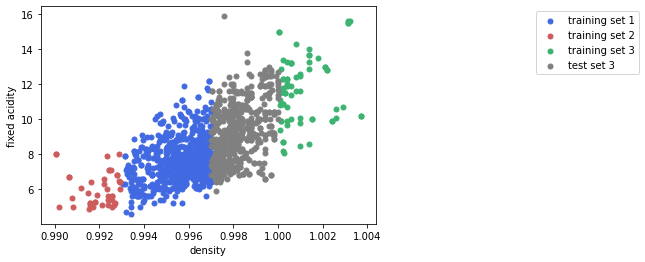

In [ ]:
# Let's plot the three training sets and the test set
plt.scatter(X1_train, Y1_train, s=100, marker='.', color="royalblue", label="training set 1")
plt.scatter(X2_train, Y2_train, s=100, marker='.', color="indianred", label="training set 2")
plt.scatter(X3_train, Y3_train, s=100, marker='.', color="mediumseagreen", label="training set 3")
plt.scatter(X_test, Y_test, s=100, marker='.', color="grey", label="test set 3")
plt.xlabel('density')
plt.ylabel('fixed acidity')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right')
plt.show()

Now we will proceed just like we did in Section 5.2.5 and carry out linear regression on each of these three training sets

```
regr1 = linear_model.LinearRegression()
regr1.fit(X1_train, Y1_train)

regr2 = linear_model.LinearRegression()
regr2.fit(X2_train, Y2_train)

regr3 = linear_model.LinearRegression()
regr3.fit(X3_train, Y3_train)

m1 = regr1.coef_[0][0]
b1 = regr1.intercept_[0]

m2 = regr2.coef_[0][0]
b2 = regr2.intercept_[0]

m3 = regr3.coef_[0][0]
b3 = regr3.intercept_[0]
```

In [ ]:
regr1 = linear_model.LinearRegression()
regr1.fit(X1_train, Y1_train)

regr2 = linear_model.LinearRegression()
regr2.fit(X2_train, Y2_train)

regr3 = linear_model.LinearRegression()
regr3.fit(X3_train, Y3_train)

m1 = regr1.coef_[0][0]
b1 = regr1.intercept_[0]

m2 = regr2.coef_[0][0]
b2 = regr2.intercept_[0]

m3 = regr3.coef_[0][0]
b3 = regr3.intercept_[0]

```
# Let's see how well they fit/predict the total dataset (note that usually we would only look at the test set here)
Y_calc_1 = regr1.predict(X_test)
Y_calc_2 = regr2.predict(X_test)
Y_calc_3 = regr3.predict(X_test)
```

In [ ]:
# Let's see how well they fit/predict the total dataset (note that usually we would only look at the test set here)
Y_calc_1 = regr1.predict(X_test)
Y_calc_2 = regr2.predict(X_test)
Y_calc_3 = regr3.predict(X_test)

In [ ]:
print(regr1.coef_, regr2.coef_, regr2.coef_, regr.coef_)
print(regr1.intercept_, regr2.intercept_, regr2.intercept_, regr.intercept_)

[[364.58367637]] [[-31.26050292]] [[-31.26050292]] [[616.01314281]]
[-355.4032878] [37.03326828] [37.03326828] [-605.68800868]


Let's visualize the fitted values using our trained models and compare to the average fit

```
# Lets plot exact positions respect to the time values using a scatter plot
plt.scatter(X_test, Y_test, s=100, marker='o', facecolors='lightgrey', edgecolors='slategrey', label="test data")
plt.xlabel('time [hours]')
plt.ylabel('position [miles]')

# Compute the average calculated position
Y_calc_ave =  ( Y_calc_1 + Y_calc_2 + Y_calc_3 ) / 3

# Now we compare to our fit by plotting both Y_cal and Y_calc_2 respect to time 
plt.plot(X_test, Y_calc_1, color='royalblue',linewidth=3, label='linear fit 1')
plt.plot(X_test, Y_calc_2, color='indianred',linewidth=3, label='linear fit 2')
plt.plot(X_test, Y_calc_3, color='mediumseagreen',linewidth=3, label='linear fit 3')
plt.plot(X_test, Y_calc_ave, color='dimgrey',linewidth=3, label='average fit')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right')
plt.show()
```

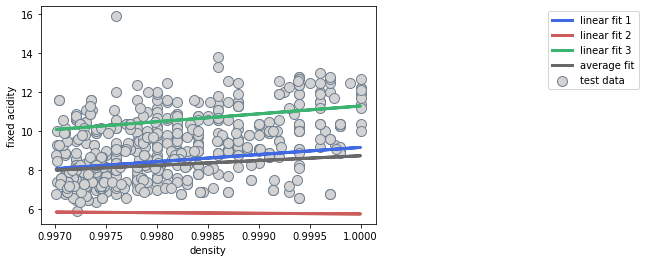

In [ ]:
# Lets plot exact positions respect to the time values using a scatter plot
plt.scatter(X_test, Y_test, s=100, marker='o', facecolors='lightgrey', edgecolors='slategrey', label="test data")
plt.xlabel('density')
plt.ylabel('fixed acidity')

# Compute the average calculated position
Y_calc_ave =  ( Y_calc_1 + Y_calc_2 + Y_calc_3 ) / 3

# Now we compare to our fit by plotting both Y_cal and Y_calc_2 respect to time 
plt.plot(X_test, Y_calc_1, color='royalblue',linewidth=3, label='linear fit 1')
plt.plot(X_test, Y_calc_2, color='indianred',linewidth=3, label='linear fit 2')
plt.plot(X_test, Y_calc_3, color='mediumseagreen',linewidth=3, label='linear fit 3')
plt.plot(X_test, Y_calc_ave, color='dimgrey',linewidth=3, label='average fit')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right')
plt.show()

#### Question 4
Why do you think each linear fit has a different slope and intercept? 


In the plot we see that each trained model has a different slope and intercept. The average fit is shown in grey. The difference between what one of the trained model predicts and the average model prediction is what we call the **_variance_**.

The variance is the amount by which the prediction will change if different subsets of the training data sets are used. We generally want to have a low variance as that ensure that our model is not sensitive to small fluctuations in the dataset.

Large variance occurs when the model performs well on the training dataset but does not do well on the test dataset.

If we use more complex models to fit, for example polynomials, that will generally lead to a larger variance.

### 5.3.2.2 Bias

Now, let's imagine that we are given the "true" universal acidity with respect to density function for red wine, lets call it <code> true_acidity </code> we define it below

```
def true_acidity(d):
    return 364 * d + -352
```

In [ ]:
def true_acidity(d):
    return 364 * d + -352

How well are we doing in terms of our prediction error respect to the true values? Are we biased? Let's visualize our results

```
plt.plot(X_test, true_acidity(X_test), color='mediumseagreen',linewidth=3, label='true relationship')
plt.plot(X_test, Y_calc_ave, color='dimgrey',linewidth=3, label='average fit')
plt.scatter(X_test, Y_test, s=100, marker='o', facecolors='lightgrey', edgecolors='slategrey', label="test data")
plt.xlabel('density')
plt.ylabel('fixed acidity')
plt.legend(bbox_to_anchor=(1.9, 1), loc='upper right')
plt.show()
```

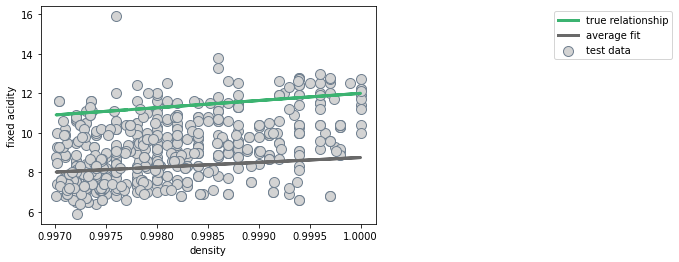

In [ ]:
plt.plot(X_test, true_acidity(X_test), color='mediumseagreen',linewidth=3, label='true relationship')
plt.plot(X_test, Y_calc_ave, color='dimgrey',linewidth=3, label='average fit')
plt.scatter(X_test, Y_test, s=100, marker='o', facecolors='lightgrey', edgecolors='slategrey', label="test data")
plt.xlabel('density')
plt.ylabel('fixed acidity')
plt.legend(bbox_to_anchor=(1.9, 1), loc='upper right')
plt.show()

We see that our model is biased, indeed our average fit model predicts with a **_bias_** error respect to the true relationship. 

In this case, a more complex function, such as a polynomial might give a better fit and a lower **_bias_**.
<div>

<img src="attachment:cheetah_over_underfitting.png" align=left width="400"/>
</div>



<div>
<img src=https://drive.google.com/uc?export=view&id=1DXLgVKjzBrofSPtxtNcVb9Lf_FbUMcKe width="500">
</div>

We usually want to find a sweet spot which minimizes both bias and variance. As we increase complexity, for instance by using a polynomial fit, our bias goes down however variance increases. Similarly for a very simple model the bias is large while the variance is small. We can see this graphically in the sketch copied below



<div>
<img src=https://drive.google.com/uc?export=view&id=1phnDnjjGJ8twf7h9JKS3TbbN5QlBFj9o width="500">
</div>

### 5.3.3 Beyond a single input feature

The **acidity** of the wine (the dependent variable v) could depend on:

* potassium from the soil (increases alkalinity)
* unripe grapes (increases acidity)
* grapes grown in colder climates or reduced sunshine create less sugar (increases acidity)
* preprocessing such as adding tartaric acid to the grape juice before fermentation (increases acidity)
* malolactic fermentation (reduces acidity)
* \+ others

You will look at using multiple features in the breakout room
<hr style="border:1px solid grey"> </hr>


## 5.4 Multivariate regression

Let's now turn our attention to wine quality.

The value we aim to predict or evaluate is the quality of each wine in our dataset. This is our dependent variable. We will look at how this is related to the 12 other independent variables, also known as *input features*.

In [ ]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 5.4.4 Linear regression on the entire wine dataset 

For this example, notice we have a categorical data variable in the 'type' column. We will ignore this for now, and only work with our red wines. In the future we will discuss how to deal with categorical variable such as this in a mathematical representation.

In [ ]:
X = red.dropna(axis=0)[red.columns[1:-1]].values
Y = red.dropna(axis=0)['quality'].values

In [ ]:
red.dropna(axis=0)['quality']

4898    5
4899    5
4900    5
4901    6
4902    5
       ..
6491    6
6492    5
6494    6
6495    5
6496    6
Name: quality, Length: 1593, dtype: int64

In [ ]:
red.dropna(axis=0)[red.columns[1:-1]]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4898,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
4899,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
4900,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
4901,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4902,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6491,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2




```
# Create linear regression object - note that we are using all the input features
regr = linear_model.LinearRegression()
regr.fit(X, y)
Y_calc = regr.predict(X)
```



In [ ]:
# Create linear regression object - note that we are using all the input features
regr = linear_model.LinearRegression()
regr.fit(X, Y)
Y_calc = regr.predict(X)

Let's see what the coefficients look like ... 

```
print("Fit coefficients: \n", regr.coef_, "\nNumber of coefficients:", len(regr.coef_))
```

In [ ]:
print("Fit coefficients: \n", regr.coef_, "\nNumber of coefficients:", len(regr.coef_))

Fit coefficients: 
 [ 2.31215425e-02 -1.08879929e+00 -1.90125690e-01  1.65692894e-02
 -1.84728753e+00  4.37027358e-03 -3.28148828e-03 -1.61186259e+01
 -4.14919204e-01  9.15511224e-01  2.78643003e-01] 
Number of coefficients: 11


We have 11 !!! That's because we are regressing respect to all **11 independent variables**!!!

So now, $$y_{\sf calc}= m_1x_1 +\, m_2x_2 \,+ \,m_3x_3 \,+\,... \,+ \,b =\sum_{i=1}^{13}m_i x_i + b\;\;\;\;\; \sf eq. 7$$

```
print("We have 13 slopes / weights:\n\n", regr.coef_)
print("\nAnd one intercept: ", regr.intercept_)
```

In [ ]:
print("We have 11 slopes / weights:\n\n", regr.coef_)
print("\nAnd one intercept: ", regr.intercept_)

We have 11 slopes / weights:

 [ 2.31215425e-02 -1.08879929e+00 -1.90125690e-01  1.65692894e-02
 -1.84728753e+00  4.37027358e-03 -3.28148828e-03 -1.61186259e+01
 -4.14919204e-01  9.15511224e-01  2.78643003e-01]

And one intercept:  20.207227258319527


```
# This size should match the number of columns in X
if len(X[0]) == len(regr.coef_):
    print("All good! The number of coefficients matches the number of input features.")
else:
    print("Hmm .. something strange is going on.")
```

In [ ]:
# This size should match the number of columns in X
if len(X[0]) == len(regr.coef_):
    print("All good! The number of coefficients matches the number of input features.")
else:
    print("Hmm .. something strange is going on.")

All good! The number of coefficients matches the number of input features.


Let's **evaluate the error** by computing the MSE and $R^2$ metrics (see eq. 3 and 6).

```
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(Y, Y_calc))
print('Coefficient of determination: %.2f' % r2_score(Y, Y_calc))
```

In [ ]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(Y, Y_calc))
print('Coefficient of determination: %.2f' % r2_score(Y, Y_calc))

Mean squared error: 0.42
Coefficient of determination: 0.36


We can also look at how well the computed values match the true values graphically by generating a scatterplot.

```
# Scatterplot
sns.scatterplot(x=Y_calc,y=Y, color="cornflowerblue", s=50)
plt.title("Linear regression - computed values on entire data set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()
```

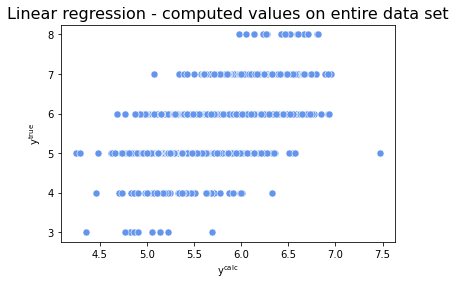

In [ ]:
# Scatterplot
sns.scatterplot(x=Y_calc,y=Y, color="cornflowerblue", s=50)
plt.title("Linear regression - computed values on entire data set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

### 5.4.5 Let's use regression to predict the housing cost

To see whether we can predict, we will carry out our regression only on a part, 70%, of the full data set. This part is called the **training** data. We will then test the trained model to predict the rest of the data, 30% - the **test** data. The function which fits won't see the test data until it has to predict it. 

We start by splitting out data using scikit-learn's <code> train_test_split() </code> function:

<code> X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=9) </code>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=9)

Now we check the size of <code> y_train </code> and <code> y_test </code>, the sum should be the size of y! If this works then we move on and carry out regression but we only use the training data!

```
if len(y_test)+len(y_train) == len(Y):
    
    print('All good, ready to C-HACK and regress!\n')
    
    # Carry out linear regression
    print('Running linear regression algorithm on the training set\n')
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

    # Predict on the test set
    Y_calc_test = regr.predict(X_test)
```

In [ ]:
if len(y_test)+len(y_train) == len(Y):
    
    print('All good, ready to C-HACK and regress!\n')
    
    # Carry out linear regression
    print('Running linear regression algorithm on the training set\n')
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

    # Predict on the test set
    Y_calc_test = regr.predict(X_test)

All good, ready to C-HACK and regress!

Running linear regression algorithm on the training set

Fit coefficients and intercept:

 [ 2.04452401e-02 -1.16060085e+00 -1.07388180e-01  1.14531703e-02
 -2.13529170e+00  5.63101144e-03 -3.44954596e-03 -1.43709592e+01
 -3.11853407e-01  8.06206215e-01  2.61442035e-01] 

 18.449655489619


Now we can plot our predicted values to see how accurate we are in predicting. We will generate a scatterplot and computing the MSE and $R^2$ metrics of error.

```
sns.scatterplot(x=Y_calc_test, y=y_test, color="mediumvioletred", s=50)
plt.title("Linear regression - predict test set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, Y_calc_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, Y_calc_test))
```

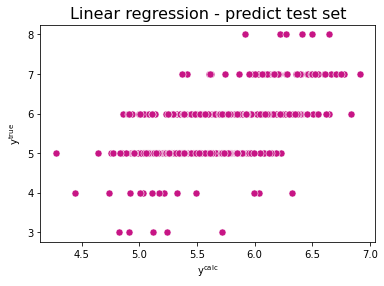

Mean squared error: 0.41
Coefficient of determination: 0.37


In [ ]:
sns.scatterplot(x=Y_calc_test, y=y_test, color="mediumvioletred", s=50)

plt.title("Linear regression - predict test set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, Y_calc_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, Y_calc_test))

#### Exercise 6
Play with the size of the train and test set - how does that change the error?

In [ ]:
# Cell for Exercise 6

### 5.4.6 Other Considerations: Do we need all independent variables? Can we output integer quality scores? Can we include red and white in one model?

We will look at prediction ability as a function of input features in the BREAKOUT ROOM, right after the break!

### 5.4.7 Are there other ways to carry our regression?

Yes! There are many - for example Ridge Regression, LASSO, Random Forests ... you will see one of these in the BREAKOUT ROOM / one example below

```
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

# Predict on the test set
Y_calc_test = regr.predict(X_test)
```

In [ ]:
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

# Predict on the test set
Y_calc_test = regr.predict(X_test)

Fit coefficients and intercept:

 [ 0.01333993 -1.18203959 -0.13151237  0.00366343 -1.37693169  0.0056349
 -0.00335109 -0.01434277 -0.29876742  0.69096798  0.28276714] 

 3.975964712465705


```
sns.scatterplot(x=Y_calc_test, y=y_test, color="lightseagreen", s=50)
plt.title("Ridge regression - predict test set",fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, Y_calc_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, Y_calc_test))
```

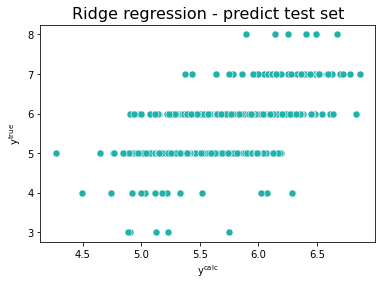

Mean squared error: 0.41
Coefficient of determination: 0.37


In [ ]:
sns.scatterplot(x=Y_calc_test, y=y_test, color="lightseagreen", s=50)
plt.title("Ridge regression - predict test set",fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, Y_calc_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, Y_calc_test))

# Breakout Room


### Problem 1) Number and choice of input features / Bias and variance

Load the red wine dataset and evaluate how the linear regression predictions changes as you change the **number and choice of input features**. The total number of columns in X  is 11 and each column represent a specific input feature. Estimate the MSE and compute the **variance / estimate the bias** for different training dataset slices.
```
print(X_train.shape)
```

In [ ]:
print(X_train.shape)

(1115, 11)


If you want to use the first 5 features you could proceed as following:

```
X_train_five = X_train[:,0:5]
X_test_five = X_test[:,0:5]
```

In [ ]:
X_train_five = X_train[:,0:5]
X_test_five = X_test[:,0:5]

Check that the new variables have the shape your expect

```
print(X_train_five.shape)
print(X_test_five.shape)
```

In [ ]:
print(X_train_five.shape)
print(X_test_five.shape)

(1115, 5)
(478, 5)


Now you can use these to train your linear regression model and repeat for different numbers or sets of input features! Note that you do not need to change the output feature! It's size is independent from the number of input features, yet recall that its length is the same as the number of values per input feature.

Questions to think about while you work on this problem
- How many input feature variables does one need? Is there a maximum or minimum number? 
- Are the conclusions you make on one dataset general?
- Could one input feature variable be better than the rest?
- What if values are missing for one of the input feature variables - is it still worth using it?
- How do the bias and variance change for each method? Try using different slices of your training dataset and compare the predictions as we did for the density vs acidity model

### Problem 2) Type of regression algorithm


If you are already a Python expert and want to try something different, try using other types of linear regression methods on the wine dataset: the LASSO model and the Elastic net model which are described by the 

<code > sklearn.linear_model.ElasticNet() </code> <br>
<code > sklearn.linear_model.Lasso() </code>

scikit-learn functions.

For more detail see [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) and [Lasso](  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso).

Questions to think about while you work on this problem
- How does the error change with each model?
- Which model seems to perform best?
- Does one model do better than the other at determining which input features are more important?
- How about non linear regression / what if the data does not follow a line?
- How do the bias and variance change for each model

<hr style="border:1px solid grey"> </hr>

# References

* **Linear Regression**
To find out more see https://en.wikipedia.org/wiki/Simple_linear_regression

* **scikit-learn**
 * Scikit-learn: https://scikit-learn.org/stable/
 * Linear regression in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
 * Metrics of error: https://scikit-learn.org/stable/modules/model_evaluation.html
  * The Boston dataset: https://scikit-learn.org/stable/datasets/index.html#boston-dataset

* **Pearson correlation**
To find out more see https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

* **Irreducible error, bias and variance**
 * Great Coursera videos here: https://www.coursera.org/lecture/ml-regression/irreducible-error-and-bias-qlMrZ
and here: https://www.coursera.org/lecture/ml-regression/variance-and-the-bias-variance-tradeoff-ZvP40
